# Convolutional Neural Network Example

This notebook demonstrates how to train and test a convolutional neural network (CNN) on your data. 

As before, we'll load in the German Traffic Signs data, pre-process it, and then use it to train the model. 

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def readTrafficSigns(rootpath, test_set = 0):
    '''
    Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Input: path to the traffic sign data, for example './GTSRB/Training'
    Output:   list of images, list of corresponding labels
    '''
    
    # Initialize the lists to store images, labels: 
    images = [] # images
    labels = [] # corresponding labels
    
    # loop over all 42 classes
    for c in range(0,43):
        # The csv contains annotations for each image.
        # Path to csv file: 
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file

        
        # Open and start reading the lines of the csv file: 
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        
        # loop over all images in current annotations file
        for row in gtReader:
            # Add each image and label to their respective lists
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        # Finally, close the csv file when we're done.
        gtFile.close()
        
    return images, labels

Don't forget to set your path! 

In [2]:
my_path = './Images' # Change this to whatever you had in the last notebook

This time, we will convert the images to grayscale and resize them, but we WON'T reshape the images. 

The CNN will work on each image as it is! 

In [3]:
def convert_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (28,28))
    return gray

In [4]:
def find_images_by_label(X, y, label):
    """
    Inputs: Data matrices X and y, and desired label to match 
    Outputs: Desired subset of X and y matrices (with consistent formatting)
    """
    X_sub = []
    y_sub = []

    for i in range(len(y)):       
        if(int(y[i])==int(label)):
            X_sub.append(convert_image(X[i]))   
            y_sub.append(int(label))

    return X_sub, y_sub

In [5]:
def make_data_array(trainImages, trainLabels, label_list):
    """
    Inputs: training images/labels data, plus a list of labels we want to keep
    Outputs: train/test splits of reduced X, y matrices 
    """
    
    X_store, y_store = find_images_by_label(trainImages, trainLabels, label_list[0])
    
    for i in range(1, len(label_list)):
        X_temp, y_temp = find_images_by_label(trainImages, trainLabels, label_list[i])
               
        X_store = np.append(X_store, X_temp, axis=0)
        y_store = np.append(y_store, y_temp, axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(X_store, y_store, test_size=0.33, random_state=42)
    return X_train, y_train, X_test, y_test



In [6]:
trainImages, trainLabels = readTrafficSigns(my_path)
# To get all the labels: 
# index_list = range(0,len(np.unique(trainLabels)))
# Here we'll use the first two classes, since they're harder to distinguish: 
label_list = [0, 1]
x_train, y_train, x_test, y_test = make_data_array(trainImages, trainLabels, label_list)

Import keras, which allows us to use Tensorflow to create the CNN: 

In [7]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

Using TensorFlow backend.


In [8]:
batch_size = 128
num_classes = 2
epochs = 10

# input image dimensions
img_x, img_y = 28, 28

# Re-shaping the data array into a form the CNN model expects: 
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# scale the image by max intensity value
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1628, 28, 28, 1)
1628 train samples
802 test samples


In [9]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Build the model! 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# compile the model 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# do some stuff to let us track the accuracy 
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

# Fit the model on your training data
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])

# Evaluate the model on your test data 
score = model.evaluate(x_test, y_test, verbose=0)

# Print the scores: 
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 1628 samples, validate on 802 samples
Epoch 1/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.3715 - acc: 0.9122 - val_loss: 0.3120 - val_acc: 0.9165
Epoch 2/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.3252 - acc: 0.9122 - val_loss: 0.2888 - val_acc: 0.9165
Epoch 3/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.2997 - acc: 0.9122 - val_loss: 0.2601 - val_acc: 0.9165
Epoch 4/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.2515 - acc: 0.9189 - val_loss: 0.2065 - val_acc: 0.9239
Epoch 5/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.2012 - acc: 0.9312 - val_loss: 0.1603 - val_acc: 0.9289
Epoch 6/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.1262 - acc: 0.9527 - val_loss: 0.0814 - val_acc: 0.9788
Epoch 7/10
1628/1628 [==============================] - 2s 1ms/step - loss: 0.0608 - acc: 0.9816 - val_loss: 0.0384 - val_acc: 0.9938
Epoch 8/10
1628

Now we can plot the accuracy as it improved (hopefully) in 'time'

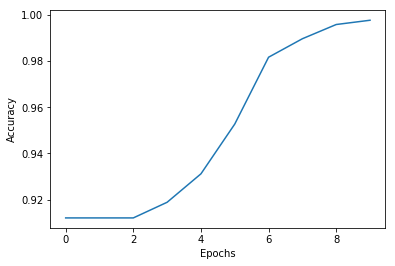

In [10]:
plt.plot(history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Finally, let's see how to test one example image from the test set.

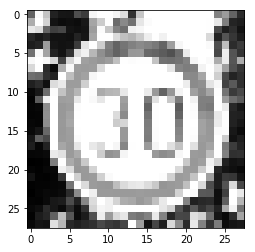

In [11]:
plt.imshow(x_test[0][:,:,0], cmap='gray')
plt.show()

In [12]:
test_img = x_test[0]
test_img = test_img.reshape(1, img_x, img_y, 1)
pred = model.predict(test_img)
print('Prediction for class 0: %.2f', pred[0][0])
print('Prediction for class 1: %.2f', pred[0][1])


Prediction for class 0: %.2f 1.893943e-05
Prediction for class 1: %.2f 0.99998105


What class does the neural network think this example is in? 